In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
import pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j, wigner_6j

sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State

In [34]:
from functions import find_state_idx_from_state, make_transform_matrix
from functions import make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state, matrix_to_states
from state_functions import find_exact_states, calculate_BR
from hamiltonian_functions import reduced_basis_hamiltonian
from laser_functions import optical_coupling_matrix, ED_ME_mixed_state, calculate_power_needed, laser_field
from collapse_functions import collapse_matrices
from density_functions import generate_density_matrix

## X State Hamiltonian

In [35]:
H_X_uc = make_hamiltonian("./stored_data/TlF_X_state_hamiltonian_J0to4.pickle")

In [36]:
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [37]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./stored_data/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [38]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [39]:
D, V = np.linalg.eigh(H_X)

# Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

# Remove very small entries from V
# V[np.abs(V) < 1e-5] = 0

# New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)
state.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [40]:
# Define what states are to be included in the simulation
Js_g = [0,1,2]
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag)

In [41]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

# Set small off diagonal terms to zero
H_X_red[np.abs(H_X_red) < 0.1] = 0

## B State Hamiltonian

In [42]:
H_B = make_hamiltonian_B("./stored_data/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [43]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [44]:
D,V = np.linalg.eigh(H_B)

# Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

# New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)
state.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [45]:
# Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag)

In [46]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Optical Couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [47]:
# Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

# Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = find_exact_states(ground_states_laser_approx, H_X_diag, QN_X_diag)

#Excited states for laser
excited_states_laser = excited_states

In [48]:
%%time
# Coupling laser for z-polarized
H_laser_z = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                             reduced = False)
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_z, H_laser_z.conj().T))

# Check number of couplings added
print(H_laser_z[np.abs(H_laser_z)>0].shape)

True
(16,)
Wall time: 42.4 s


In [49]:
%%time
H_laser_x = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([1,0,0]), 
                                             reduced = False)
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_x, H_laser_x.conj().T))

# Check number of couplings added
print(H_laser_x[np.abs(H_laser_x)>0].shape)

True
(32,)
Wall time: 42.3 s


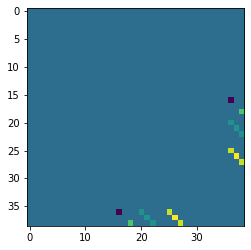

In [50]:
plt.imshow(H_laser_z.real)

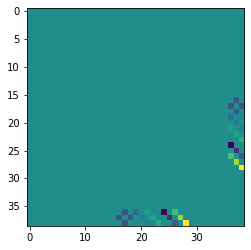

In [51]:
plt.imshow(H_laser_x.real)

In [52]:
# Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate

# Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

# Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

In [53]:
ME_main

(-0.39444661382277774+0j)

## Collapse Operators

In [60]:
Gamma = 1/100e-9 # 2*pi [Hz]

In [61]:
excited_test_approx = 1*CoupledBasisState(J = 1, F1=3/2, F=1, mF=0, I1=1/2, I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_test_i = find_state_idx_from_state(H_B_diag,excited_test_approx, QN_B_diag)
excited_test = QN_B_diag[excited_test_i]

ground_test_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_test_i = find_state_idx_from_state(H_X_diag,ground_test_approx, QN_X_diag)
ground_test = QN_X_diag[ground_test_i]

BRs = calculate_BR(excited_test, ground_states)

In [62]:
C_array = collapse_matrices(QN, ground_states, excited_states, gamma = Gamma)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

In [63]:
np.save('C_array', C_array)

## Density Matrix

In [64]:
# Define states that are populated initially
Js = [0,1,2]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])
    
pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

In [65]:
import scipy.constants as cst

def boltzmann_distribution(rot_constant, temperature, J_list):
    init = np.zeros(len(J_list))
    Z = 0
    g = 1
    for J in J_list:
        g = 4*(2*J+1)
        Z += g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))
    for idx, J in enumerate(J_list):
        g = 4*(2*J+1)
        init[idx] = g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))/Z
    return init

In [66]:
B_0 = 6.68667*1e9 # Hz
T = 7
boltz_dist = boltzmann_distribution(B_0,T, np.arange(0,150,1))

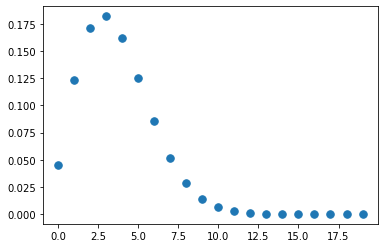

In [67]:
plt.plot(boltz_dist[:20], '.', ms = 15)

In [68]:
def get_J_indices(J_list):
    spans = []
    for J in J_list:
        spans.append(4*(2*J+1))
    indices = [(0,spans[0])]
    for idx,span in enumerate(spans[1:]):
        s = np.sum(spans[:idx+1])
        indices.append((s, s+span))
    return indices

In [69]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    print(idx, idx_max-idx_min, boltz_dist[idx]/(idx_max-idx_min))
    np.fill_diagonal(rho_ini[sl], boltz_dist[idx]/(idx_max-idx_min))
rho_ini /= np.diag(rho_ini).sum()

0 4 0.011286978903789161
1 12 0.01029811954327005
2 20 0.008572714492675116


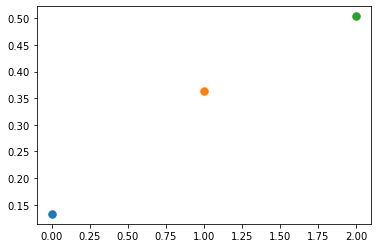

In [70]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    plt.plot(idx, np.sum(np.diag(rho_ini[sl])).real, '.', ms = 15)

## Total Hamiltonian

In [33]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [34]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

In [35]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

In [54]:
np.save('H_laser_x', H_laser_x)
np.save('H_laser_z', H_laser_z)
np.save('H_X_red', H_X_red)
np.save('H_B_red', H_B_red)
np.save('H_B_diag', H_B_diag)

## Some parameter definitions

In [36]:
# Generate optical coupling matrix with set rabi rate
Omega = np.abs(4.5*Gamma*ME_main)

# Define frequency for polarization switching
omega_p = Gamma
wp = omega_p/(2*np.pi)

## Lindblad Function

In [37]:
def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [38]:
H_oc_t = lambda t, Omega, wp: (Omega/ME_main)/2*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))

def Hamiltonian(t, Omega, wp):
    return _H + H_oc_t(t, Omega, wp)

In [39]:
def Lindblad_rhs(t, rho_vec, p):
    Omega, wp = p
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))

    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]

    rhs = (-1j* (Hamiltonian(t, Omega, wp) @ rho - rho @ Hamiltonian(t, Omega, wp)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

## Sympy

In [40]:
from sympy import Symbol, Function, zeros, conjugate
from tqdm import tqdm

In [41]:
t = Symbol("t", real = True)
Ω = Symbol("Ω", real = True)

In [42]:
Px = Function("Px")(t)
Pz = Function("Pz")(t)

In [43]:
def recursive_subscript(i):
    if i < 10:
        return chr(0x2080+i)
    else:
        return recursive_subscript(i//10)+chr(0x2080+i%10)

In [44]:
density_matrix = zeros(39,39)

In [45]:
levels = 39
for i in range(levels):
    for j in range(i,levels):
        # \u03C1 is unicode for ρ, chr(0x2080+i) is unicode for
        # subscript num(i), resulting in ρ₀₀(t) for example
        if i == j:
            density_matrix[i,j] = Symbol(u'\u03C1{0},{1}'. \
            format(recursive_subscript(i), recursive_subscript(j)))
        else:
            density_matrix[i,j] = Symbol(u'\u03C1{0},{1}'. \
            format(recursive_subscript(i), recursive_subscript(j)))
            density_matrix[j,i] = Symbol(u'\u03C1{1},{0}'. \
            format(recursive_subscript(i), recursive_subscript(j)))

In [46]:
Ham = zeros(39,39)
Ham += ((Ω/ME_main)/2)*(H_laser_z*Pz + H_laser_x*Px)
Ham += _H

In [47]:
_s = zeros(39,39)
for idx in tqdm(range(C_array.shape[0])):
    _s[:,:] += C_array[idx]@density_matrix@C_conj_array[idx]

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [05:21<00:00,  9.75s/it]


In [48]:
a = -0.5 * (Cprecalc@density_matrix + density_matrix@Cprecalc)
b = -1j*(Ham@density_matrix - density_matrix@Ham)
res = zeros(39,39)
res += _s
res += b
res += a

In [52]:
code_lines = []
for idx in tqdm(range(res.shape[0])):
    for idy in range(res.shape[0]):
        if res[idx,idy] != 0:
            cline = str(res[idx,idy])
            cline = f"du[{idx+1},{idy+1}] = " + cline
            cline = cline.replace("Px(t)", "Px")
            cline = cline.replace("Pz(t)", "Pz")
            cline = cline.replace("I", "1im")
            cline += '\n'
            for i in range(res.shape[0]):
                for j in range(res.shape[1]):
                    _ = str(density_matrix[i,j])
                    for __ in [f'conjugate({_})', _]:
                        cline = cline.replace(__+"*", f"u[{i+1},{j+1}]*")
                        cline = cline.replace(__+" ", f"u[{i+1},{j+1}] ")
                        cline = cline.replace(__+"\n", f"u[{i+1},{j+1}]")
                        cline = cline.replace(__+")", f"u[{i+1},{j+1}])")
            cline = cline.strip()
            code_lines.append(cline)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:32<00:00,  1.21it/s]


## Julia Code

In [53]:
from julia import Main

In [54]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using StaticArrays""")
Main.eval("""using LinearAlgebra""")
Main.eval("""using BenchmarkTools""")

In [55]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [56]:
ode_fun = """
function Lindblad_rhs!(du, u, p, t)
\t@inbounds begin
\t\tΩ = p[1]
\t\tωp = p[2]
\t\tPx = square_wave(t, ωp, 3.141592653589793)
\t\tPz = square_wave(t, ωp, 0.0)    
"""
ode_fun = ode_fun

In [57]:
print(ode_fun)


function Lindblad_rhs!(du, u, p, t)
	@inbounds begin
		Ω = p[1]
		ωp = p[2]
		Px = square_wave(t, ωp, 3.141592653589793)
		Pz = square_wave(t, ωp, 0.0)    



In [58]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [59]:
with open('ode_fun.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [60]:
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

In [242]:
# Generate optical coupling matrix with set rabi rate
Main.Omega = np.abs(4.5*Gamma*ME_main)

# Define frequency for polarization switching
Main.omega_p = Gamma
Main.wp = omega_p/(2*np.pi)

# Define initial population
Main.rho_ini = rho_ini

In [243]:
Main.eval("""
p = [Omega, wp]
""")

array([17750097.622025  ,  1591549.43091895])

In [245]:
%%time
Main.eval("""
du = zeros(ComplexF64,39,39)
@benchmark Lindblad_rhs!(du, rho_ini, p, 1e-8)
""")

Wall time: 4.14 s


<PyCall.jlwrap Trial(5.057 μs)>

In [64]:
Main.eval("du = zeros(ComplexF64,39,39)")
Main.eval("test_input = rand(ComplexF64,39,39)")
Main.eval("Lindblad_rhs!(du, test_input, p, 1e-8)")
comp_julia = Main.du
comp_python = Lindblad_rhs(1e-8, Main.test_input.flatten(), Main.p).reshape(39,39)

(array([ 0,  0,  0, ..., 38, 38, 38], dtype=int64),
 array([ 0,  1,  2, ..., 36, 37, 38], dtype=int64))

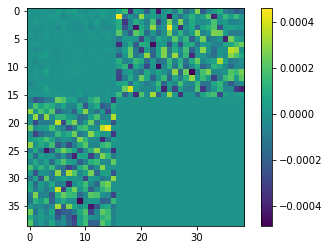

In [65]:
fig, ax = plt.subplots()
c = ax.imshow((comp_python.imag - comp_julia.imag))
fig.colorbar(c)
np.nonzero(comp_python.imag - comp_julia.imag)

(array([ 0,  0,  0, ..., 38, 38, 38], dtype=int64),
 array([ 0,  1,  2, ..., 36, 37, 38], dtype=int64))

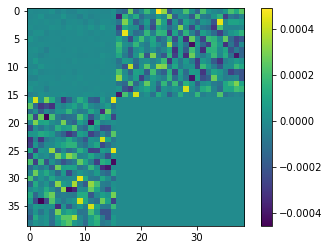

In [66]:
fig, ax = plt.subplots()
c = ax.imshow(comp_python.real - comp_julia.real)
fig.colorbar(c)
np.nonzero(comp_python.real - comp_julia.real)

In [67]:
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan,p)
tmp = 0
""")

0

In [68]:
%%time
Main.eval("""
sol = solve(prob, Tsit5())
tmp = 0
""")

Wall time: 6.92 s


0

In [69]:
%%time
Main.eval("""
sol = solve(prob, Tsit5())
tmp = 0
""")

Wall time: 252 ms


0

3.3213728523421624


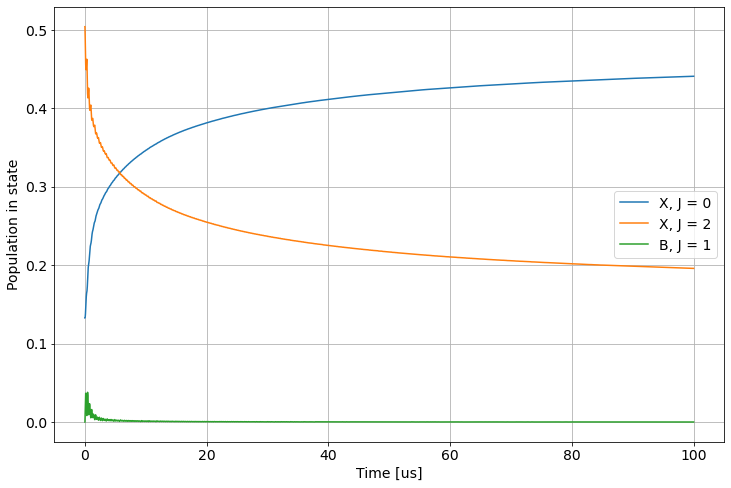

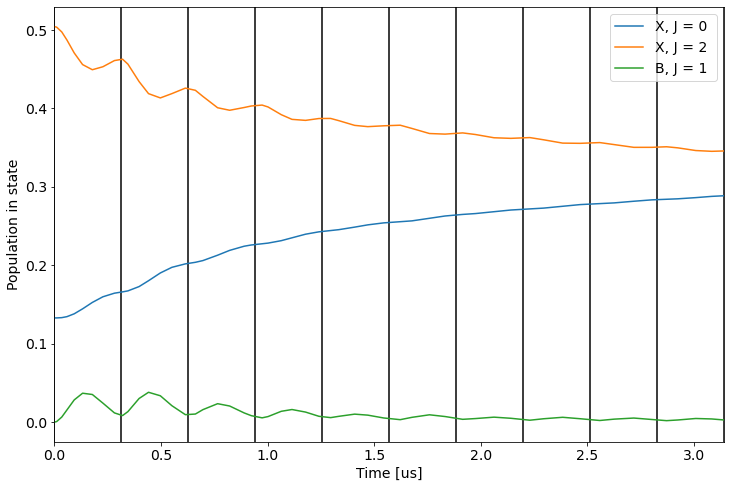

In [70]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')
    
print(P0[-1]/P0[0])

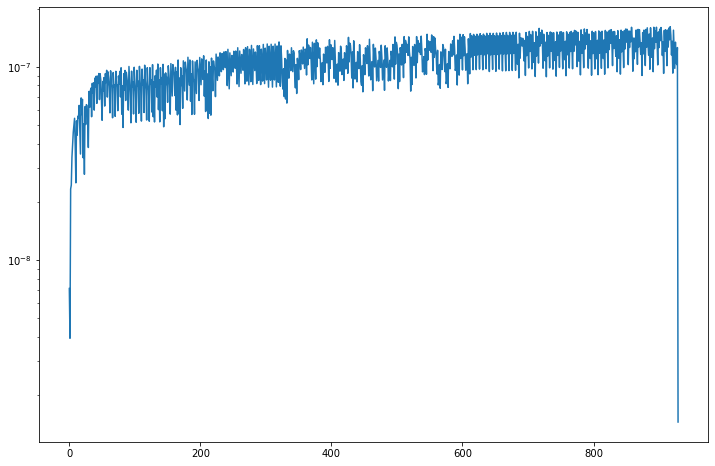

In [71]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.diff(t_array))
ax.set_yscale('log')

## Sensitivity Sweep

In [143]:
Main.eval("""
p = [Omega, wp]
""")

array([17750097.622025  ,  1591549.43091895])

In [144]:
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan,p)
tmp = 0
""")

0

In [155]:
%%time
Main.eval(f"""
sol = solve(prob, Tsit5())
tmp = 0
""")

Wall time: 257 ms


0

In [158]:
import time
abstolerances = np.logspace(-6,-9,7)
reltolerances = np.logspace(-3,-6,7)

In [218]:
%%time
elapsed_times = []
time_arrays = []
solutions = []
for abstol, reltol in tqdm(zip(abstolerances, reltolerances), total=len(abstolerances)):
    # compile function before timing
    Main.eval(f"""
    sol = solve(prob, Tsit5(), abstol = {abstol}, reltol = {reltol})
    tmp = 0
    """)
    dt = []
    for _ in range(5):
        tstart = time.time()
        Main.eval(f"""
        sol = solve(prob, Tsit5(), abstol = {abstol}, reltol = {reltol})
        tmp = 0
        """)
        tstop = time.time()
        dt.append(tstop - tstart)
    elapsed_times.append(np.mean(dt))
    ut = np.array(Main.eval("sol[:]")).T
    pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[2]))))
    solutions.append(pop_results)
    time_arrays.append(np.array(Main.eval("sol.t")))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:03<00:00,  9.04s/it]

Wall time: 1min 3s


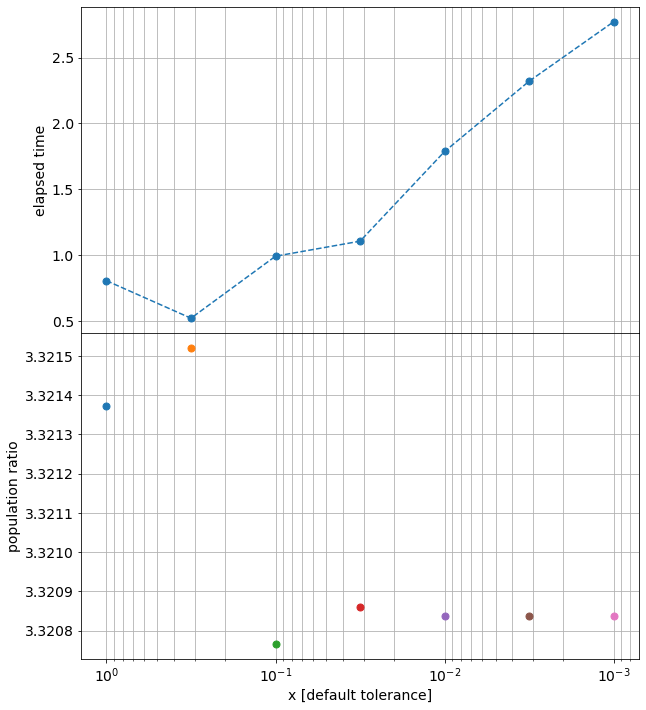

In [238]:
fig, axes = plt.subplots(2,figsize = (10,12), sharex = True, 
                         gridspec_kw = {'hspace': 0})

ax = axes[0]
ax.grid(True, which = 'both')

ax.plot(abstolerances*1e6, elapsed_times, '--.', ms = 14)

ax.set_xscale('log')
ax.set_ylabel('elapsed time', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

ax = axes[1]
ax.grid(True, which = 'both')

for t, sol, factor in zip(time_arrays, solutions, abstolerances*1e6):
    P0 = np.sum(sol[:4,:], axis = 0)
    P1 = np.sum(sol[4:16,:], axis = 0)
    P2 = np.sum(sol[16:36,:], axis = 0)
    PB1 = np.sum(sol[36:,:], axis = 0)
    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14)

ax.set_xscale('log')
ax.invert_xaxis()
ax.set_xlabel('x [default tolerance]', fontsize = 14)
ax.set_ylabel('population ratio', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

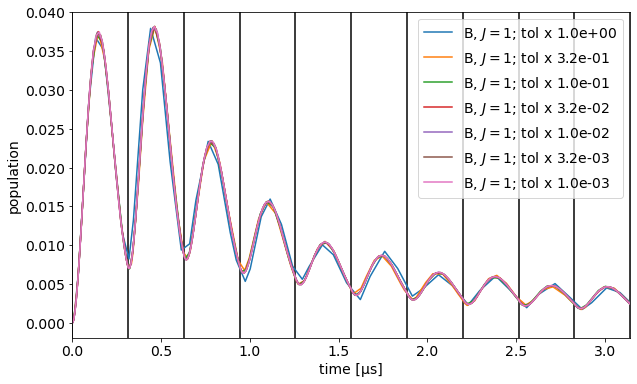

In [220]:
fig, ax = plt.subplots(figsize = (10,6))

for t, sol, factor in zip(time_arrays, solutions, abstolerances*1e6):
    P0 = np.sum(sol[:4,:], axis = 0)
    P1 = np.sum(sol[4:16,:], axis = 0)
    P2 = np.sum(sol[16:36,:], axis = 0)
    PB1 = np.sum(sol[36:,:], axis = 0)
    
#     ax.plot(t*1e6, P0, label = f'X, $J=0$')
#     ax.plot(t*1e6, P2, label = f'X, $J=2$')
    ax.plot(t*1e6, PB1, label = f'B, $J=1$; tol x {factor:.1e}')
    
ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel('population', fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')

## Parameter Sweep

In [ ]:
Main.eval("Omegas = (Omega/4.5)*(0.25:0.25:4.25)")

In [ ]:
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[Omegas[i],wp])
end
""")

In [ ]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func)
""")

In [ ]:
%%time
Main.eval("""
sim = solve(ens_prob, Tsit5(), EnsembleThreads(); trajectories= 17)
tmp = 0
""")

In [ ]:
ens_u = Main.eval("sim.u")

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

for factor, ut_ens in zip(np.arange(0.25,4.5,0.25),ens_u):
    ut_ens = np.array(ut_ens)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((rho_ini.shape[0], rho_ini.shape[1], ut_ens.shape[2]))))
    t_array = np.linspace(0, ut_ens.shape[2]-1,  ut_ens.shape[2])*5e-8
      
    P0 = np.sum(pop_results[:4], axis = 0)
    
    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14, color = 'C0')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population ratio", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

In [77]:
Main.eval("""
a = 0.25:0.125:10
b = 0.1:0.05:5
c = zeros(length(a)*length(b), 2)
for i = 1:length(a)
  for j = 1:length(b)
     c[(i-1)*length(b)+j,1] = a[i]
     c[(i-1)*length(b)+j,2] = b[j] 
  end
end
""")

In [78]:
Main.eval("""
c[:,1] .*= Omega/4.5
c[:,2] .*= wp
tmp = 0
""")

0

In [79]:
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[c[i,1],c[i,2]])
end
""")

<PyCall.jlwrap prob_func>

In [80]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [123]:
%%time
Main.eval("""
sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = size(c)[1] , dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
tmp = 0
""")

Wall time: 9min 41s


0

In [124]:
ens_u = Main.eval("sim.u")

In [125]:
results = {}

for (Omega_factor, wp_factor), ut_ens in tqdm(zip(Main.c,ens_u), total = len(ens_u)):
    ut_ens = np.array(ut_ens)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((rho_ini.shape[0], rho_ini.shape[1], ut_ens.shape[2]))))
    P0 = np.sum(pop_results[:4], axis = 0)
    results[(round(Omega_factor/(Omega/4.5),2), round(wp_factor/wp,2))] = P0[-1]/P0[0]

100%|████████████████████████████████████████████████████████████████████████████| 7821/7821 [00:02<00:00, 2797.16it/s]


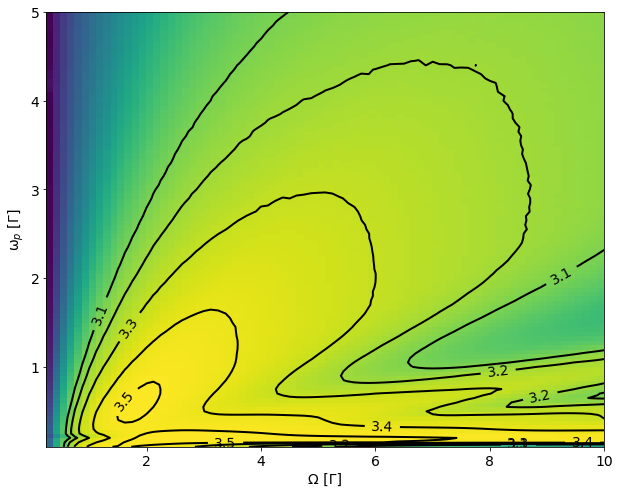

In [241]:
x,y = zip(*list(results.keys()))

X = np.array(x).reshape(len(Main.a),len(Main.b))
Y = np.array(y).reshape(len(Main.a),len(Main.b))
Z = np.array(list(results.values())).reshape(len(Main.a),len(Main.b))

fig, ax = plt.subplots(figsize = (10,8))
ax.pcolormesh(X,Y,Z)
cs = ax.contour(X,Y,Z, colors = 'k', levels = [3.1, 3.2, 3.3, 3.4, 3.45],
           linewidths = 2)
ax.clabel(cs, cs.levels, inline=True, fmt='%.1f', fontsize=14)


ax.set_xlabel("Ω [Γ]", fontsize = 14)
ax.set_ylabel(r"ω$_p$ [Γ]", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

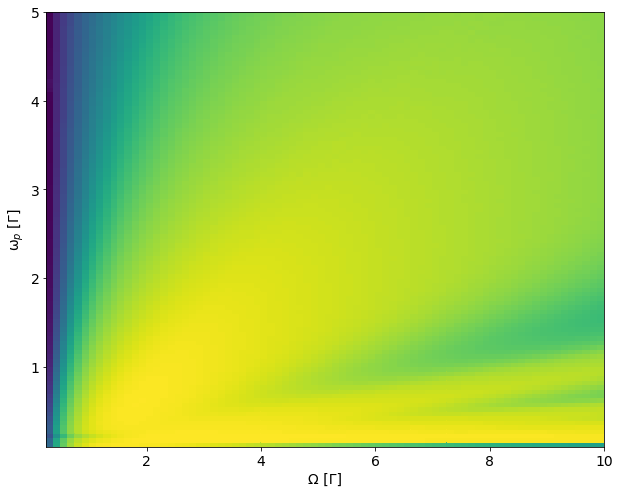

In [127]:
fig, ax = plt.subplots(figsize = (10,8))
ax.pcolormesh(X,Y,Z)

ax.set_xlabel("Ω [Γ]", fontsize = 14)
ax.set_ylabel(r"ω$_p$ [Γ]", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

## Try DiffEqGPU

GPU is vastly slower than the CPU threads version, not sure why yet.

In [179]:
Main.eval("using DiffEqGPU")
Main.eval("using CuArrays")
Main.eval("using CUDA")

In [170]:
Main.eval("""
function square_wave(t, frequency, phase)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [171]:
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

In [172]:
Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan,p)
tmp = 0
""")

0

In [174]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, safetycopy=false)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [190]:
Main.eval("CUDA.allowscalar(false)")

In [ ]:
%%time
Main.eval("""
sim = solve(ens_prob, Tsit5(), EnsembleGPUArray(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = 200, dt = 1e-9, adaptive=true)
tmp = 0
""")

In [186]:
ens_u = Main.eval("sim.u")

In [187]:
results = {}

for (Omega_factor, wp_factor), ut_ens in tqdm(zip(Main.c,ens_u), total = len(ens_u)):
    ut_ens = np.array(ut_ens)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((rho_ini.shape[0], rho_ini.shape[1], ut_ens.shape[2]))))
    P0 = np.sum(pop_results[:4], axis = 0)
    results[(round(Omega_factor/(Omega/4.5),2), round(wp_factor/wp,2))] = P0[-1]/P0[0]

100%|████████████████████████████████████████████████████████████████████████████| 7821/7821 [00:02<00:00, 2750.49it/s]


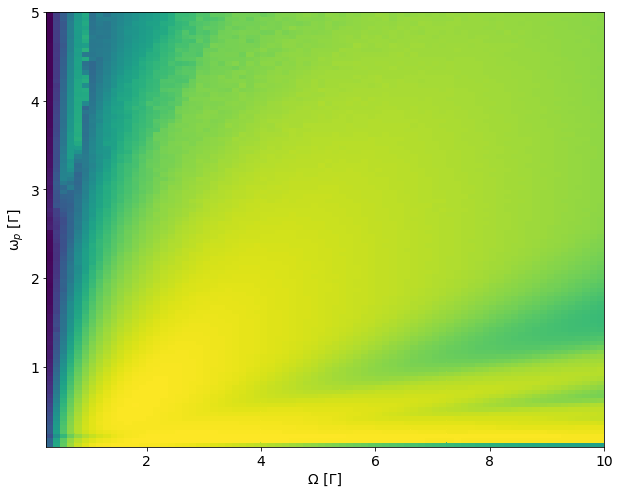

In [189]:
x,y = zip(*list(results.keys()))

X = np.array(x).reshape(len(Main.a),len(Main.b))
Y = np.array(y).reshape(len(Main.a),len(Main.b))
Z = np.array(list(results.values())).reshape(len(Main.a),len(Main.b))

fig, ax = plt.subplots(figsize = (10,8))
ax.pcolormesh(X,Y,Z)

ax.set_xlabel("Ω [Γ]", fontsize=14)
ax.set_ylabel(r"ω$_p$ [Γ]", fontsize=14)
ax.tick_params(axis='both', labelsize=14)